### Let’s start the mission!m
First, import the necessary packages

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

Import the dataset. This is an excel dataset. Here training data and cross-validation data are stored in the separate sheets. So, let’s bring the training data.

In [7]:
df = pd.read_excel('ex8data1.xlsx', sheet_name='X', header=None)
df.head()

,0,1
0,13.046815,14.741152
1,13.408520,13.763270
2,14.195915,15.853181
3,14.914701,16.174260
4,13.576700,14.042849


Let’s plot column 0 against column 1.

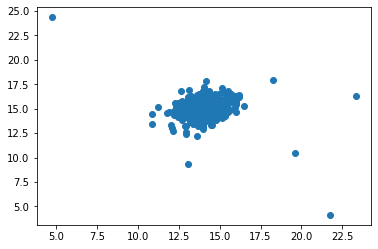

In [8]:
plt.figure()
plt.scatter(df[0], df[1])
plt.show()

You probably know by looking at this graph which data are anomalous.
Check how many training examples are in this dataset:

In [10]:
m = len(df)
m

307

Calculate the mean for each feature. Here we have only two features: 0 and 1.

In [19]:
mu = np.mean(df,axis=0)
mu

0    14.112226
1    14.997711
dtype: float64

From the formula described in the ‘Formulas and Process’ section above, let’s calculate the variance:

In [21]:
variance = np.mean((df - mu)**2, axis=0)
variance

0    1.832631
1    1.709745
dtype: float64

Now make it diagonal shaped. As I explained in the ‘Formulas and Process’ section after the probability formula, that summation sign was actually the diagonals of the variance.

In [22]:
var_dia = np.diag(variance)
var_dia

array([[1.83263141, 0.        ],
       [0.        , 1.70974533]])

Calculate the probability:

In [24]:
k = len(mu)
X = df - mu
p = 1/((2*np.pi)**(k/2)*(np.linalg.det(var_dia)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(var_dia) * X,axis=1))
p

0      6.470829e-02
1      5.030417e-02
2      7.245035e-02
3      5.031575e-02
4      6.368497e-02
           ...     
302    3.981340e-02
303    5.455673e-08
304    4.461721e-12
305    6.107184e-05
306    2.912867e-23
Length: 307, dtype: float64

The training part is done.
Let’s put all these calculations for probability into a function for future use.

In [25]:
def probability(df):
    mu = np.mean(df, axis=0)
    variance = np.mean((df - mu)**2, axis=0)
    var_dia = np.diag(variance)
    k = len(mu)
    X = df - mu
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(var_dia)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(var_dia) * X,axis=1))
    return p

The next step is to find out the threshold probability. If the probability is lower than the threshold probability, the example data is anomalous data. But we need to find out that threshold for our particular case.

For this step, we use cross-validation data and also the labels. In this dataset, we have the cross-validation data and also the labels in separate sheets.

>_**For your case, you can simply keep a portion of your original data for cross-validation.**_

Now import the cross-validation data and the labels:

In [26]:
cvx = pd.read_excel('ex8data1.xlsx', sheet_name='Xval', header=None)
cvx.head()

,0,1
0,15.790260,14.921024
1,13.639619,15.329955
2,14.865899,16.473865
3,13.584676,13.989306
4,13.464042,15.635330


Here are the labels:

In [27]:
cvy = pd.read_excel('ex8data1.xlsx', sheet_name='y', header=None)
cvy.head()

,0
0,0
1,0
2,0
3,0
4,0


>_**The purpose of cross-validation data is to calculate the threshold probability. And we will use that threshold probability to find the anomalous data of df.**_

Now call the probability function we defined before to find the probability for our cross-validation data ‘cvx’:

In [28]:
p1 = probability(cvx)

I will convert ‘cvy’ to a NumPy array just because I like working with arrays. DataFrames are also fine though.

In [38]:
y = np.array(cvy)

Here, the value of ‘y’ 0 suggests that that’s a normal example and the ‘y’ value of 1indicates that, it is an anomalous example.

### Now, how to select a threshold?

I do not want to just check for all the probability from our list of probability. That may be unnecessary. Let’s examine the probability values some more.

In [31]:
p.describe()

count    3.070000e+02
mean     5.905331e-02
std      2.324461e-02
min      1.181209e-23
25%      4.361075e-02
50%      6.510144e-02
75%      7.849532e-02
max      8.986095e-02
dtype: float64

As you can see in the picture, we do not have too many anomalous data. So, if we just start from the 75% value, that should be good. But just to be extra safe I will start the range from the mean.

So, we will take a range of probabilities from the mean value and lower. We will check the f1 score for each probability of this range.

First, define a function to calculate the true positives, false positives, and false negatives:

In [40]:
def tpfpfn(ep, p, y):
    tp, fp, fn = 0, 0, 0
    for i in range(len(y)):
        if p[i] <= ep and y[i][0] == 1:
            tp += 1
        elif p[i] <= ep and y[i][0] == 0:
            fp += 1
        elif p[i] > ep and y[i][0] == 1:
            fn += 1
    return tp, fp, fn

Make a list of the probabilities that are lower than or equal to the mean probability.

In [41]:
eps = [i for i in p1 if i <= p1.mean()]

Check, the length of the list,

In [42]:
len(eps)

128

Define a function to calculate the ‘f1’ score as per the formula we discussed before:

In [44]:
def f1(ep, p, y):
    tp, fp, fn = tpfpfn(ep,p,y)
    prec = tp/(tp + fp)
    rec = tp/(tp + fn)
    f1 = 2*prec*rec/(prec + rec)
    return f1

All the functions are ready!
Now calculate the f1 score for all the epsilon or the range of probability values we selected before.

In [46]:
f = []
for i in eps:
    f.append(f1(i, p1,y))
f

[0.16470588235294117,
 0.208955223880597,
 0.15384615384615385,
 0.3181818181818182,
 0.15555555555555556,
 0.125,
 0.56,
 0.13333333333333333,
 0.16867469879518074,
 0.12612612612612614,
 0.14583333333333331,
 0.22950819672131148,
 0.15053763440860213,
 0.16666666666666666,
 0.3888888888888889,
 0.12389380530973451,
 0.10294117647058823,
 0.19999999999999998,
 0.25925925925925924,
 0.1372549019607843,
 0.17283950617283952,
 0.13592233009708737,
 0.10370370370370369,
 0.17073170731707316,
 0.18918918918918923,
 0.27999999999999997,
 0.12844036697247707,
 0.23333333333333334,
 0.15909090909090906,
 0.10852713178294573,
 0.5833333333333334,
 0.1044776119402985,
 0.25,
 0.1473684210526316,
 0.12173913043478261,
 0.13861386138613863,
 0.10769230769230768,
 0.18666666666666665,
 0.11023622047244096,
 0.24137931034482757,
 0.2121212121212121,
 0.12068965517241378,
 0.3333333333333333,
 0.30434782608695654,
 0.14285714285714285,
 0.17721518987341772,
 0.5185185185185185,
 0.7368421052631577,


This is a part of the f score list. The length should be 128. The f scores are usually ranged between 0 and 1 where 1 is the perfect f score. The higher the f1 score the better. So, we need to take the highest f score from the list of ‘f’ scores we just calculated.
Now, use the ‘argmax’ function to determine the index of the maximum f score value.

In [47]:
np.array(f).argmax()

127

And now use this index to get the threshold probability.

In [49]:
e = eps[127]
e

0.00014529639061630078

### Find out the Anomalous Examples

We have the threshold probability. We can find out the labels of our training data from it.

If the probability value is lower than or equal to this threshold value, the data is anomalous and otherwise, normal. We will denote the normal and anomalous data as 0 and 1 respectively,

In [50]:
label = []
for i in range(len(df)):
    if p[i] <= e:
        label.append(1)
    else:
        label.append(0)
label

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


I will add this calculated labels in the training dataset above:

In [51]:
df['label'] = np.array(label)
df.head()

,0,1,label
0,13.046815,14.741152,0
1,13.408520,13.763270,0
2,14.195915,15.853181,0
3,14.914701,16.174260,0
4,13.576700,14.042849,0


I plotted the data where the label is 1 in red color and where the label is zero in black. Here is the plot.

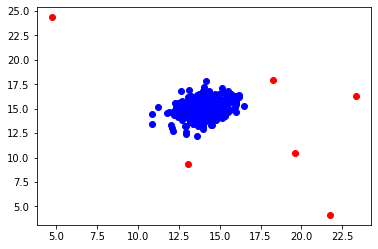

In [61]:
plt.figure()
for i in range(len(label)):
    if label[i] == 0:
        plt.scatter(df[0][i], df[1][i],color='b')
    if label[i] == 1:
        plt.scatter(df[0][i], df[1][i],color='r')
        
plt.show()

### Does it make sense?
It does, right? The data in red are clearly anomalous.

### Conclusion
I tried to explain the process to develop an anomaly detection algorithm step by step. I did not leave any steps hidden here. I hope it is understandable. If you are having trouble understanding just by reading it, I suggest run every piece of code by yourself in a notebook. That will make it very clear.
Please do not hesitate to share, if you are doing some cool projects using this algorithm.